In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
import xgboost as xgb
import joblib
import os


# Download the data and first look

In [2]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 📥 2. Cargar datos
df = pd.read_csv("..\DATA\medical_examination.csv")  # Usualmente este dataset usa ';' como separador
df.head()


<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Sebastian.Martinez\AppData\Local\Temp\ipykernel_668\1920559854.py:5: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv("..\DATA\medical_examination.csv")  # Usualmente este dataset usa ';' como separador


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None


In [4]:
for col in df.columns:
    print(f"Columna: {col}")
    print(df[col].unique())
    print("-" * 40)

Columna: id
[    0     1     2 ... 99996 99998 99999]
----------------------------------------
Columna: age
[18393 20228 18857 ... 14925 17727 17926]
----------------------------------------
Columna: gender
[2 1 3]
----------------------------------------
Columna: height
[168 156 165 169 151 157 178 158 164 173 181 172 170 154 162 163 153 159
 166 155 160 175 171 152 187 148 179 180 188 185 167 183 174 176 161 184
 177 182  76 149 142 150 144 147 186 146 141 195 140 198 145 143 196 138
 194 190 134 136 100 120 189 137 192 122 250 191 117  70  97 119 130 110
 193  75 132  71 135  67 125 139 133  74  98 112 207  68  55  81  80  64
  91  60 109  72 197  65 128 105 108 200 104 111 113  96 131  59  66  99
  57]
----------------------------------------
Columna: weight
[ 62.    85.    64.    82.    56.    67.    93.    95.    71.    68.
  80.    60.    78.   112.    75.    52.    83.    69.    90.    45.
  65.    59.    66.    74.   105.    73.    55.    70.    72.    63.
  50.   107.    84. 

In [5]:
print(df.describe())


                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349843    164.359229     74.205690   
std    28851.302323   2467.251667      0.477253      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      3.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.472530      0.680250    

We can identify that there are anomalous values such as heights less than 55 cm or negative pressures. Althrought nan values in gender variable

# Clean Data

In [6]:
# Replace column names with more descriptive names
df = df.rename(columns={
    'age': 'age_days',
    'gender': 'gender',  # 1: Female, 2: Male
    'ap_hi': 'systolic',
    'ap_lo': 'diastolic',
    'cholesterol': 'cholesterol',
    'gluc': 'glucose',
    'smoke': 'smoke',
    'alco': 'alcohol',
    'active': 'physical_activity',
    'cardio': 'target'
})

# Convert days to years
df['age_days'] = (df['age_days'] / 365).astype(int)

# Replace gender values
df['gender'] = df['gender'].map({1: 'Female', 2: 'Male'})

# Drop rows with missing values on gender
df = df.dropna(subset=['gender'])

# Convert cm to meters
df['height'] = df['height'] / 100  

# BMI calculation
df['bmi'] = round(df['weight'] / (df['height'] ** 2),2)

# BMI Categorization function
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal weight'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obesity'

# Apply BMI categorization
df['bmi_category'] = df['bmi'].apply(categorize_bmi)

# ADD hypertension column
df['hypertension'] = ((df['systolic'] > 140) | (df['diastolic'] > 90)).astype(int)

# Add PAM (Pressure Arterial Mean)
df['pam'] = round(df['diastolic'] + (df['systolic'] - df['diastolic']) / 3,2)

# Add pulse pressure
df['pulse_pressure'] = df['systolic'] - df['diastolic']

# Filter out invalid data
df=df[(df['systolic'] > 70) & (df['diastolic'] >40)]
df=df[(df['systolic'] < 250) & (df['diastolic'] < 150)]
df=df[(df['systolic'] > df['diastolic'])]
df=df[(df['height'] >=1.40) & (df['height'] <=2.10)]
df=df[(df['weight'] >=40) & (df['weight'] <=200)]

# Export new csv file
df.to_csv("..\DATA\medical_examination_cleaned.csv", index=False, sep=';', decimal=',')


<>:61: SyntaxWarning: invalid escape sequence '\D'
<>:61: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Sebastian.Martinez\AppData\Local\Temp\ipykernel_668\1407705906.py:61: SyntaxWarning: invalid escape sequence '\D'
  df.to_csv("..\DATA\medical_examination_cleaned.csv", index=False, sep=';', decimal=',')


# Distribution

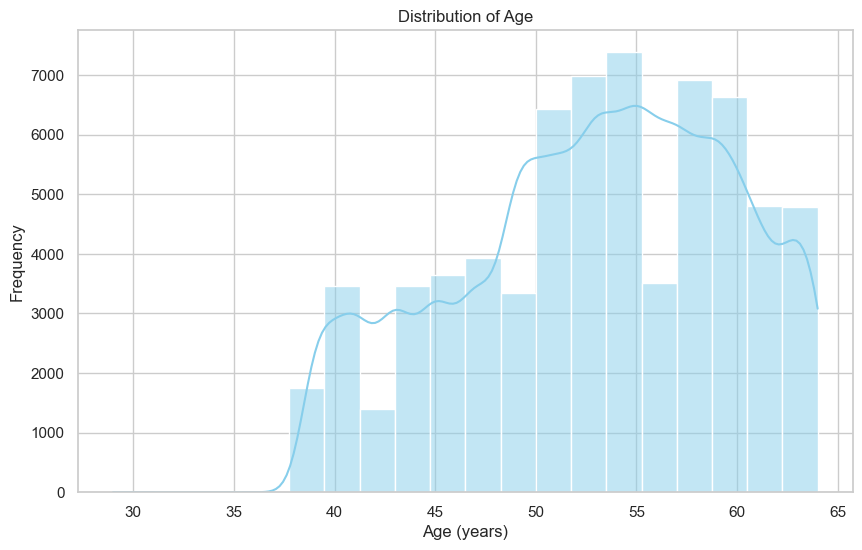

In [7]:
sns.histplot(df['age_days'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

(np.float64(-1.0999996469265718),
 np.float64(1.0999999210047584),
 np.float64(-1.0999997479630312),
 np.float64(1.0999999879982396))

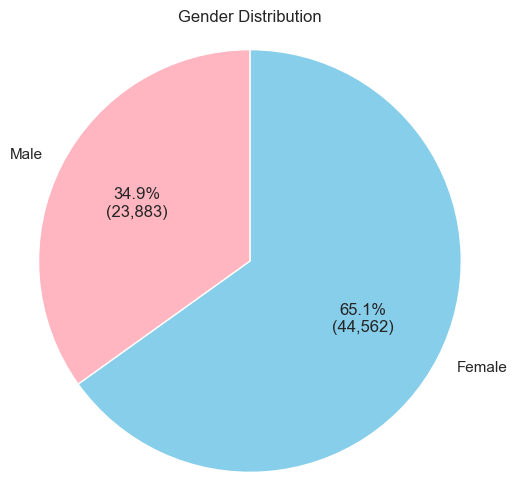

In [8]:

genero_counts = df['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    genero_counts,
    labels=genero_counts.index,
    autopct=lambda p: '{:.1f}%\n({:,.0f})'.format(p, p * genero_counts.sum() / 100),
    colors=['#87ceeb', '#ffb6c1'],
    startangle=90,
    counterclock=False
)
plt.title('Gender Distribution')
plt.axis('equal')  

We have an imbalance that we will have to fix later when we want to train the model.

target      0      1
gender              
Female  22626  21936
Male    11951  11932


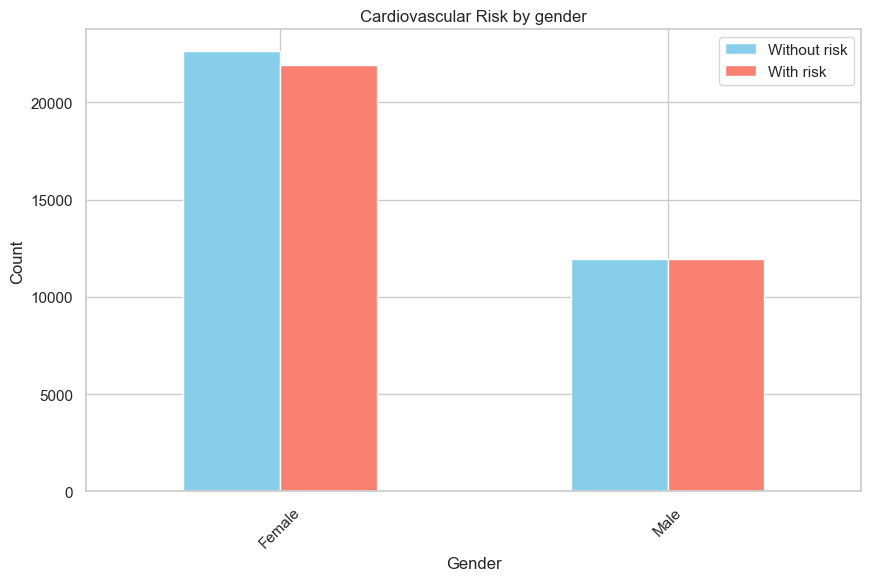

In [9]:
# Count of cardiovascular risk by gender
conteo = df.groupby('gender')['target'].value_counts().unstack()
print(conteo)

conteo.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])
plt.title('Cardiovascular Risk by gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(['Without risk', 'With risk'])

There appears to be no difference in risk between genders. They seems to have the same probability

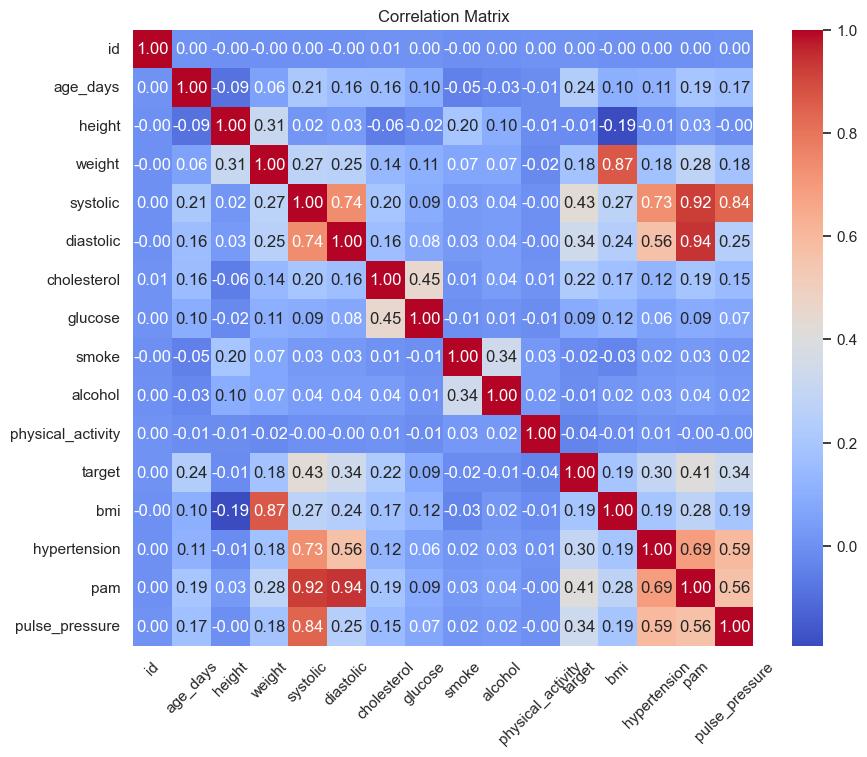

Correlation with target variable:
target               1.000000
systolic             0.428082
pam                  0.410282
diastolic            0.341700
pulse_pressure       0.337060
hypertension         0.299353
age_days             0.239184
cholesterol          0.221305
bmi                  0.191548
weight               0.179743
glucose              0.089335
id                   0.003601
alcohol             -0.008456
height              -0.013161
smoke               -0.016319
physical_activity   -0.037735
Name: target, dtype: float64


In [10]:
# Correlation analysis
corr = df.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

print("Correlation with target variable:")
print(corr['target'].sort_values(ascending=False)) 

We see that the factors with which there is the greatest linear relationship are: Sistolic pressure, PAM, diastolic and pulse pressure. 

It's worth to see those varaibles more in datail. 

The visualization of the data will be done on POWER BI

# MACHINE LEARNING MODELS

## Setting the data

In [11]:

# Create a DataFrame only with gender column and the original index
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
_, y_gender = rus.fit_resample(df[['gender']], df['gender'])

# Obtayn the indices selected by the sampling
idx = y_gender.index

# Filter the original DataFrame to keep only the balanced rows
df_balanced = df.loc[idx].reset_index(drop=True)

# Balance X and y for ML
X = df_balanced.drop(['target','bmi_category'], axis=1) # Drop extra columns
y = df_balanced['target']

# OneHotEncoder for gender
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]), 
                         columns=encoder.get_feature_names_out(categorical_cols), 
                         index=X.index)
X_numeric = X.drop(categorical_cols, axis=1)
X_final = pd.concat([X_numeric, X_encoded], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)



## Testing differents models

In [12]:
# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


# 3. XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)



# Calculate classification reports
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1-score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ]
}

df_results = pd.DataFrame(results)
print(df_results)

c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.686205   0.726175  0.585893  0.648535
1        Random Forest  0.721583   0.736299  0.680153  0.707113
2              XGBoost  0.726502   0.748468  0.672527  0.708468


We took XGBoost as the best model and tried to improve it.

In [13]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01,0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1]
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-pac

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.7198792313752893


I evaluate the best model with the best parameters.

In [14]:

# Use the best parameters to create the final model
best_xgb = grid.best_estimator_

# Cross-validation to evaluate the model
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb, X_final, y, cv=skf, scoring='f1')

print("F1-score for each fold:", scores)
print("F1-score mean:", scores.mean())

c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:29:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:29:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:29:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Sebastian.Martinez\heart-risk-analysis\heart-risk-analysis\venv\Lib\site-pac

F1-score for each fold: [0.72610049 0.72935477 0.71738644 0.71409396 0.71065537 0.72429078
 0.70821405 0.72468917 0.71209767 0.7203371 ]
F1-score mean: 0.7187219796622996


Model final test

In [15]:
# Use the best parameters to create the final model
best_xgb = grid.best_estimator_

# Predict on the test set
y_pred_best = best_xgb.predict(X_test)

# Calculate metrics
print("XgBoost Optimized Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1-score:", f1_score(y_test, y_pred_best))

XgBoost Optimized Results:
Accuracy: 0.7360267950596608
Precision: 0.7653874004344677
Recall: 0.6716797288710019
F1-score: 0.7154783393501805


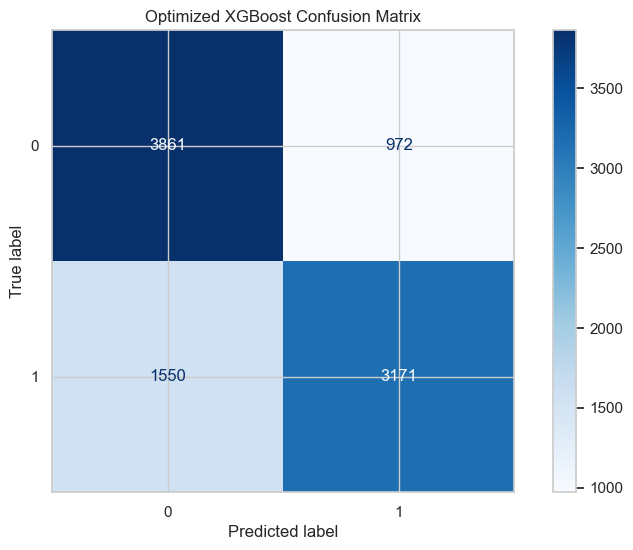

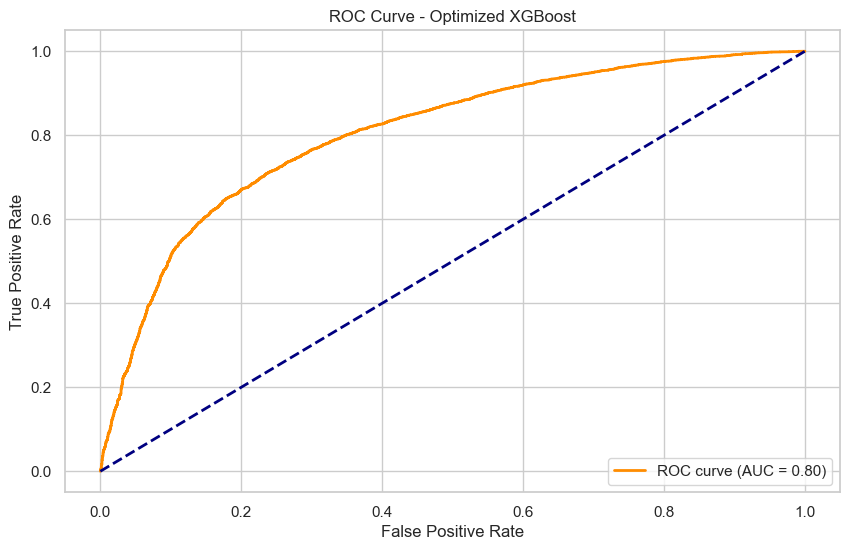

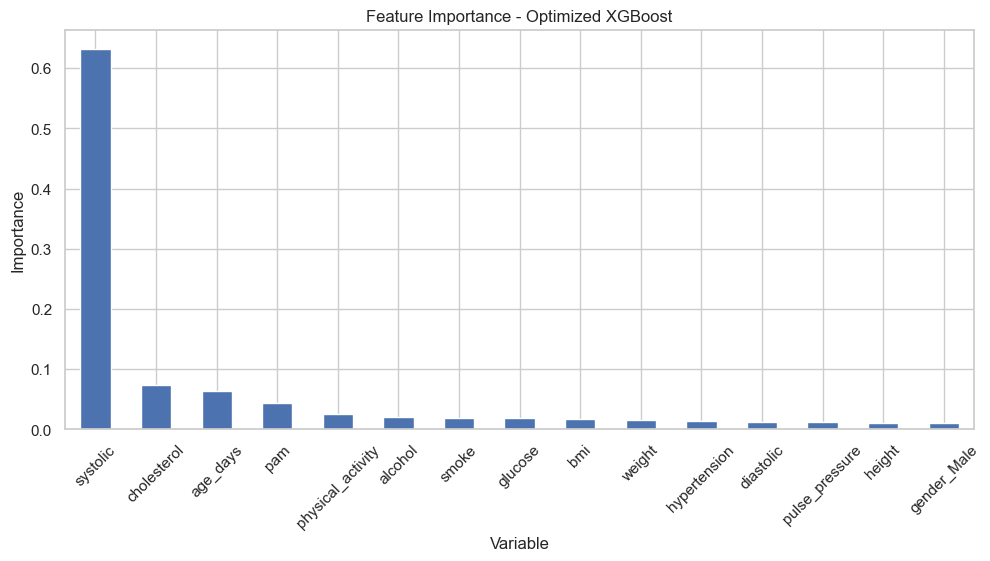

In [16]:


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Optimized XGBoost Confusion Matrix")
plt.show()

# Curve ROC y AUC
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized XGBoost')
plt.legend(loc="lower right")
plt.show()


# Feature Importance
importances = best_xgb.feature_importances_
feature_names = X_final.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(15).plot(kind='bar')
plt.title('Feature Importance - Optimized XGBoost')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Save model

In [17]:

os.makedirs("models", exist_ok=True)

# Save model
joblib.dump(best_xgb , "models/xgboost_model.joblib")

# Save metrics
metrics = {
    "accuracy": accuracy_score(y_test, y_pred_best),
    "auc": roc_auc
}
pd.Series(metrics).to_json("models/xgboost_results.json", indent=4)

# Save confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.savefig("models/confusion_matrix_xgboost.png")
plt.close()

# Guardar curva ROC
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.savefig("models/roc_curve_xgboost.png")
plt.close()